In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import Descriptors
from rdkit.Chem import rdMolTransforms
import py_rdl
import RA

# Cremer Pople Puckering Parameter

In [2]:
# Five
five = pd.read_csv("five.csv")

In [3]:
monocyclic = []
polycyclic = []
for idx, item in enumerate(five[["A0","A1","A2","A3","A4"]].values):
    if list(item)==["M","M","M","M","M"]:
        monocyclic.append(idx)
    else:
        polycyclic.append(idx)
        
mono_five = five.iloc[monocyclic].reset_index(drop=True)
poly_five = five.iloc[polycyclic].reset_index(drop=True)

mono_single = []
mono_one = []
mono_two = []
for idx, item in enumerate(mono_five[["B0","B1","B2","B3","B4"]].values):
    check = [x==1.5 or x==2.0 for x in item]
    if sum(check)==0:
        mono_single.append(idx)
    elif sum(check)==1:
        mono_one.append(idx)
    else:
        mono_two.append(idx)

poly_single = []
poly_one = []
poly_two = []
for idx, item in enumerate(poly_five[["B0","B1","B2","B3","B4"]].values):
    check = [x==1.5 or x==2.0 for x in list(item)]
    if sum(check)==0:
        poly_single.append(idx)
    elif sum(check)==1:
        poly_one.append(idx)
    else:
        poly_two.append(idx)

In [4]:
molecule = Chem.SDMolSupplier("molecule/unique.sdf")

In [29]:
result = []
smarts = Chem.MolFromSmarts("[r5]@[r5]@[r5]!@;-[!#1]")
for idx, mol in enumerate(molecule[x] for x in mono_single):
    bonds = []
    match = mol.GetSubstructMatches(smarts)
    for bond in mol.GetBonds():
        bonds.append((bond.GetBeginAtom().GetIdx(),bond.GetEndAtom().GetIdx()))
    data = py_rdl.Calculator.get_calculated_result(bonds)
    for urf in data.urfs:
        rcs = data.get_relevant_cycles_for_urf(urf)
        for rc in rcs:
            if len(list(rc.nodes))==5:
                ringloop = RA.Rearrangement(mol, list(rc.nodes))
                coord = np.array([mol.GetConformer().GetAtomPosition(atom) for atom in ringloop])
                ccoord = RA.Translate(coord)
                cptmp = RA.GetRingPuckerCoords(ccoord)
                bond = RA.GetRingBonds(mol, ringloop)
                bondtype = [item[1] for item in bond]
                atomtype = RA.GetRingAtomType(mol, ringloop)
                torsion = [rdMolTransforms.GetDihedralRad(mol.GetConformer(),*[ringloop[x] for x in [i%5,(i+1)%5,(i+2)%5,(i+3)%5]]) for i in range(5) ]
                tmp =[]
                for m in match:
                    if (m[0] in ringloop) and (m[1] in ringloop) and (m[2] in ringloop) and (ringloop.index(m[2])>ringloop.index(m[1])):
                         tmp.append((ringloop.index(m[2]), rdMolTransforms.GetDihedralRad(mol.GetConformer(), *m)))
                result.append((idx,*cptmp[0],*cptmp[1],*bondtype,*atomtype,*torsion,tmp))


In [17]:
a = pd.DataFrame(result)

k = []
for idx, i in enumerate(a.iloc[:,8:13].values):
    if list(i)==["M","M","M","M","M"]:
        k.append(idx)
        
b = a.iloc[k,:].reset_index(drop=True)

k1 = []
k0 = []
for idx, item in enumerate(b.iloc[:,3:7].values):
    check = [x==1.5 or x==2.0 for x in item]
    if sum(check)==0:
        k0.append(idx)
    elif sum(check)==1:
        k1.append(idx)

In [28]:
pd.DataFrame(result)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,0,0.284803,-2.292799,1.0,1.0,1.0,1.0,1.0,M,M,P,B,M,-0.509076,0.378891,-0.109287,-0.214590,0.457500,[]
1,2,0.007509,2.625583,1.5,1.0,1.0,1.0,1.0,B,B,M,M,M,-0.001699,-0.007884,0.013804,-0.014346,0.009863,[]
2,4,0.335531,-1.821725,1.0,1.0,1.0,1.0,1.0,P,B,M,M,B,-0.549783,0.578184,-0.389490,0.039448,0.323781,[]
3,4,0.277769,2.552405,1.0,1.0,1.0,1.0,1.0,M,P,B,B,B,-0.025527,-0.280022,0.475570,-0.473096,0.312994,[]
4,4,0.375716,0.117633,1.0,1.0,1.0,1.0,1.0,M,B,B,M,M,0.458924,-0.079451,-0.333531,0.614781,-0.658857,[]
5,5,0.117407,1.327096,1.0,1.0,1.0,1.0,1.0,M,M,M,M,M,0.202974,-0.202967,0.144287,-0.017590,-0.127622,[]
6,6,0.591087,-1.270323,2.0,1.0,1.0,1.0,1.0,M,M,P,P,B,-0.644711,0.928438,-0.916504,0.614672,0.015445,[]
7,6,0.593853,-2.539605,1.0,1.0,1.0,1.0,1.0,B,P,P,M,M,-0.939045,0.616612,0.030798,-0.662396,0.957873,[]
8,9,0.000161,2.813833,1.5,1.5,1.5,1.5,1.5,M,M,M,M,M,-0.000050,-0.000135,0.000318,-0.000351,0.000211,[]
9,13,0.002740,2.434433,1.5,1.5,1.5,1.5,1.5,M,M,M,M,M,0.000573,-0.003826,0.005746,-0.005406,0.002921,[]


In [18]:
qq = b.iloc[k0,:].reset_index(drop=True)

In [19]:
qqcp = qq.iloc[:,1:3]
qqt = qq.iloc[:,13:18]

In [20]:
Y = qqt.iloc[:,0]
X1 = np.array(qqcp.iloc[:,0]*np.cos(qqcp.iloc[:,1]))
X2 = np.array(qqcp.iloc[:,0]*np.sin(qqcp.iloc[:,1])) 

In [21]:
X = np.array([np.ones(len(X1)),X1,X2]).transpose()

In [22]:
xtx = np.linalg.inv(np.matmul(np.transpose(X),X))
xty = np.matmul(np.transpose(X),Y)

r = np.matmul(xtx,xty)

In [23]:
r

array([-7.67584045e-04,  1.06556925e+00,  1.45228565e+00])

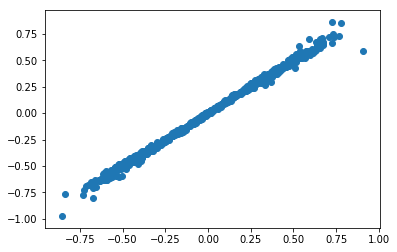

In [24]:
plt.scatter(np.matmul(X,np.transpose(np.matmul(xtx,xty))),Y)

In [25]:
Y2 = np.matmul(X,np.transpose(np.matmul(xtx,xty)))

In [26]:
k = []
w = []
for idx, item in enumerate(qq.iloc[:,18].values):
    for x in item:
        if x[0]==1:
            k.append(idx)
            w.append(x[1])

In [314]:
y3 = 1.06556925*qq.iloc[k,1]*np.cos(qq.iloc[k,2]+4*np.pi/5) + 1.45228565*qq.iloc[k,1]*np.sin(qq.iloc[k,2]+4*np.pi/5) -0.000767584
#y3 = 1.06652924*qq.iloc[k,1]*np.cos(qq.iloc[k,2]) + 1.46343720*qq.iloc[k,1]*np.sin(qq.iloc[k,2]) + 2.45539702e-04

In [315]:
e = np.column_stack([np.ones(len(y3)),y3])

In [316]:
xtx2 = np.linalg.inv(np.matmul(np.transpose(e),e))
xty = np.matmul(np.transpose(e),w)
r=  np.matmul(xtx2,xty)

In [276]:
r

array([-0.03863271,  0.14070063])

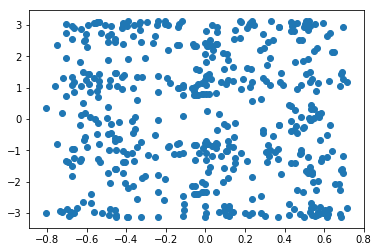

In [322]:
pp = plt.scatter(qq.iloc[k,14],w)

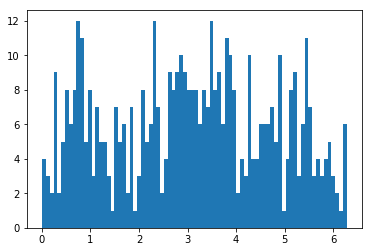

In [327]:
plt.hist(np.mod(qq.iloc[k,14]-w,2*np.pi),bins=80)
plt.show()

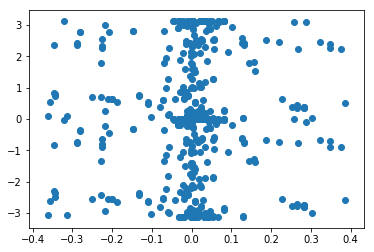

In [279]:
plt.scatter(y3,w)

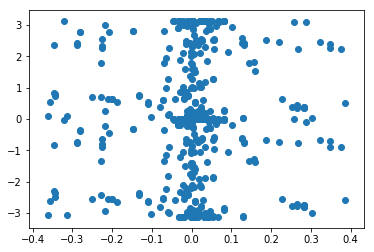

In [280]:
plt.scatter(y3,w)

In [281]:
keep = []
for idx, item in enumerate(qq.iloc[:,18].values):
    for x in item:
        if x[0]==1:
            keep.append((idx,*qq.iloc[idx,[1,2]].values.tolist(),x[1]))
    

In [282]:
w = pd.DataFrame(keep)

In [109]:
w1 = -7.67584045e-04 + 1.06556925*w.iloc[:,1]*np.cos(w.iloc[:,2]+4*np.pi/5) + 1.45228565*w.iloc[:,1]*np.sin(w.iloc[:,2]+4*np.pi/5)

In [110]:
w2 = np.array([np.ones(len(w1)),w1.values]).transpose()

In [111]:
y1 = w.iloc[:,3].values

In [115]:
xtx = np.linalg.inv(np.matmul(np.transpose(w2),w2))
xty = np.matmul(np.transpose(w2),y1)

np.matmul(xtx,xty)

array([ 0.0483072 , -0.13607817])

In [119]:
r =  0.0483072-0.1361*w2

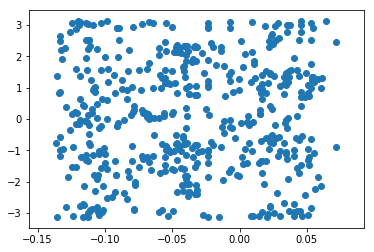

In [123]:
plt.scatter(r.sum(axis=1),y1)

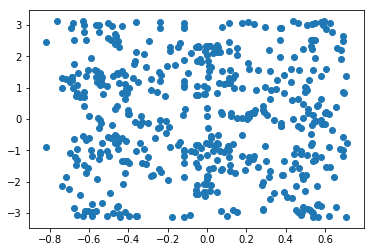

In [104]:
plt.scatter(w1,y1)

In [258]:
result = []
for idx, mol in enumerate(peptide):
    bonds = []
    for bond in mol.GetBonds():
        bonds.append((bond.GetBeginAtom().GetIdx(),bond.GetEndAtom().GetIdx()))
    data = py_rdl.Calculator.get_calculated_result(bonds)
    for urf in data.urfs:
        rcs = data.get_relevant_cycles_for_urf(urf)
        for rc in rcs:
            if len(list(rc.nodes))==12:
                ringloop = RA.Rearrangement(mol, list(rc.nodes))
                coord = np.array([mol.GetConformer().GetAtomPosition(atom) for atom in ringloop])
                ccoord = RA.Translate(coord)
                cptmp = RA.GetRingPuckerCoords(ccoord)
                bond = RA.GetRingBonds(mol, ringloop)
                bondtype = [item[1] for item in bond]
                atomtype = RA.GetRingAtomType(mol, ringloop)
                torsion = [rdMolTransforms.GetDihedralRad(mol.GetConformer(),*[ringloop[x] for x in [i%12,(i+1)%12,(i+2)%12,(i+3)%12]]) for i in range(12) ]
                result.append((idx,*cptmp[0],*cptmp[1],*bondtype,*atomtype,*torsion))


In [282]:
a = pd.DataFrame(result)

k = []
for idx, i in enumerate(a.iloc[:,22:34].values):
    if list(i)==["M","M","M","M","M","M","M","M","M","M","M","M"]:
        k.append(idx)
        
b = a.iloc[k,:].reset_index(drop=True)

In [292]:
k1 = []
k0 = []
for idx, item in enumerate(b.iloc[:,10:22].values):
    check = [x==1.5 or x==2.0 for x in item]
    if sum(check)==0:
        k0.append(idx)
    elif sum(check)==1:
        k1.append(idx)

In [416]:
pep = pd.read_csv("data/cyclic_peptide_2.csv")

In [500]:
cc1 = []
cc2 = []
for idx, item in enumerate(pep[["P1","P2","P3","P4"]].values):
    if list(item)==["C","C","C","C"]:
        cc1.append(idx)
    elif list(item) in [["C","C","C","T"],["C","T","C","C"],["C","C","T","C"]]:
        cc2.append(idx)

In [ ]:
k1 = []
k0 = []
for idx, item in enumerate(b.iloc[:,3:7].values):
    check = [x==1.5 or x==2.0 for x in item]
    if sum(check)==0:
        k0.append(idx)
    elif sum(check)==1:
        k1.append(idx)

In [67]:
a = pd.DataFrame(result)

k = []
for idx, i in enumerate(a.iloc[:,8:13].values):
    if list(i)==["M","M","M","M","M"]:
        k.append(idx)
        
b = a.iloc[k,:].reset_index(drop=True)

k1 = []
k0 = []
for idx, item in enumerate(b.iloc[:,3:7].values):
    check = [x==1.5 or x==2.0 for x in item]
    if sum(check)==0:
        k0.append(idx)
    elif sum(check)==1:
        k1.append(idx)

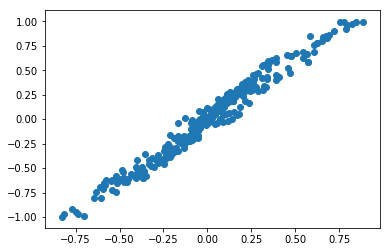

In [45]:
t1= a.iloc[k0,1]*np.cos(a.iloc[k0,2]) + a.iloc[k0,1]*np.sin(a.iloc[k0,2])
t2 = a.iloc[k0,13]
plt.scatter(t1,t2)

In [ ]:
t1= a.iloc[k0,1]*np.cos(a.iloc[k0,2]+4*np.pi/5) + a.iloc[k0,1]*np.sin(a.iloc[k0,2]+4*np.pi/5)
t2 = a.iloc[k0,14]
plt.scatter(t1,t2)
plt.show()

In [ ]:
t1= a.iloc[k0,1]*np.cos(a.iloc[k0,2]+8*np.pi/5) + a.iloc[k0,1]*np.sin(a.iloc[k0,2]+8*np.pi/5)
t2 = a.iloc[k0,15]
plt.scatter(t1,t2)

In [ ]:
t1= a.iloc[k0,1]*np.cos(a.iloc[k0,2]+12*np.pi/5) + a.iloc[k0,1]*np.sin(a.iloc[k0,2]+12*np.pi/5)
t2 = a.iloc[k0,16]
plt.scatter(t1,t2)
plt.show()

In [ ]:
t1= a.iloc[k0,1]*np.cos(a.iloc[k0,2]+16*np.pi/5) + a.iloc[k0,1]*np.sin(a.iloc[k0,2]+16*np.pi/5)
t2 = a.iloc[k0,17]
plt.scatter(t1,t2)
plt.show()

In [184]:
a = pd.DataFrame(result)

k = []
for idx, i in enumerate(a.iloc[:,10:16].values):
    if list(i)==["M","M","M","M","M","M"]:
        k.append(idx)
        
b = a.iloc[k,:].reset_index(drop=True)

k1 = []
k0 = []
for idx, item in enumerate(b.iloc[:,4:10].values):
    check = [x==1.5 or x==2.0 for x in item]
    if sum(check)==0:
        k0.append(idx)
    elif sum(check)==1:
        k1.append(idx)

(array([  5., 481.,  85.,  47.,  13.,  21.,  24.,  54., 223., 317.]),
 array([-1.42534239, -1.16060662, -0.89587084, -0.63113506, -0.36639929,
        -0.10166351,  0.16307226,  0.42780804,  0.69254382,  0.95727959,
         1.22201537]),
 <a list of 10 Patch objects>)

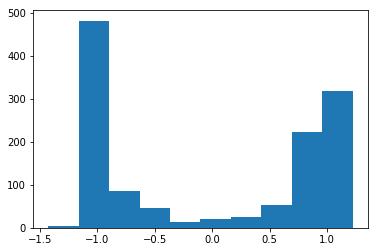

In [185]:
plt.hist(b.iloc[k0,:][16])

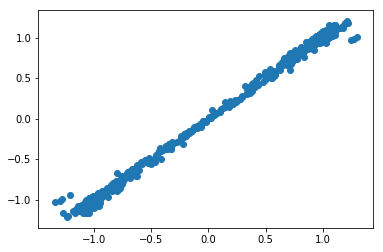

In [247]:
t1 = -0.047*b.iloc[k0,1]*np.cos(b.iloc[k0,3]+4*np.pi/3) + 1.48*b.iloc[k0,1]*np.sin(b.iloc[k0,3]+4*np.pi/3) + 1.74*b.iloc[k0,2]
t2 = b.iloc[k0,18]
plt.scatter(t1,t2)

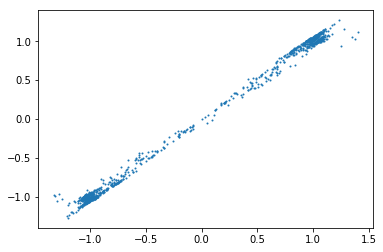

In [256]:
t1 = -0.038*b.iloc[k0,1]*np.cos(b.iloc[k0,3]+6*np.pi/3) + 1.587*b.iloc[k0,1]*np.sin(b.iloc[k0,3]+6*np.pi/3) - 1.78*b.iloc[k0,2]
t2 = b.iloc[k0,19]
plt.scatter(t1,t2,s=1)

In [396]:
a1 = b.iloc[k0,1]*np.cos(b.iloc[k0,6]+2*np.pi*2/12)
b1 = b.iloc[k0,1]*np.sin(b.iloc[k0,6]+2*np.pi*2/12)
c1 = b.iloc[k0,2]*np.cos(b.iloc[k0,7]+2*np.pi*3/12)
d1 = b.iloc[k0,2]*np.sin(b.iloc[k0,7]+2*np.pi*3/12)
e1 = b.iloc[k0,3]*np.cos(b.iloc[k0,8]+2*np.pi*4/12)
f1 = b.iloc[k0,3]*np.sin(b.iloc[k0,8]+2*np.pi*4/12)
g1 = b.iloc[k0,4]*np.cos(b.iloc[k0,9]+2*np.pi*5/12)
h1 = b.iloc[k0,4]*np.sin(b.iloc[k0,9]+2*np.pi*5/12)
i1 = b.iloc[k0,5]
Y = np.array(b.iloc[k0,36])

In [568]:
a1 = b.iloc[k0,1]*np.cos(b.iloc[k0,6])
b1 = b.iloc[k0,1]*np.sin(b.iloc[k0,6])
c1 = b.iloc[k0,2]*np.cos(b.iloc[k0,7])
d1 = b.iloc[k0,2]*np.sin(b.iloc[k0,7])
e1 = b.iloc[k0,3]*np.cos(b.iloc[k0,8])
f1 = b.iloc[k0,3]*np.sin(b.iloc[k0,8])
g1 = b.iloc[k0,4]*np.cos(b.iloc[k0,9])
h1 = b.iloc[k0,4]*np.sin(b.iloc[k0,9])
i1 = b.iloc[k0,5]
Y = np.array(b.iloc[k0,34])

In [564]:
a1 = b.iloc[k0,1]*np.cos(b.iloc[k0,6]+11*2*np.pi*2/12)
b1 = b.iloc[k0,1]*np.sin(b.iloc[k0,6]+11*2*np.pi*2/12)
c1 = b.iloc[k0,2]*np.cos(b.iloc[k0,7]+11*2*np.pi*3/12)
d1 = b.iloc[k0,2]*np.sin(b.iloc[k0,7]+11*2*np.pi*3/12)
e1 = b.iloc[k0,3]*np.cos(b.iloc[k0,8]+11*2*np.pi*4/12)
f1 = b.iloc[k0,3]*np.sin(b.iloc[k0,8]+11*2*np.pi*4/12)
g1 = b.iloc[k0,4]*np.cos(b.iloc[k0,9]+11*2*np.pi*5/12)
h1 = b.iloc[k0,4]*np.sin(b.iloc[k0,9]+11*2*np.pi*5/12)
i1 = b.iloc[k0,5]
Y = np.array(b.iloc[k0,45])

In [574]:
X = np.array([np.ones(len(a1)),a1,b1,c1,d1,e1,f1,g1,h1,i1])

In [575]:
beta = np.dot(np.linalg.inv(np.dot(X,np.transpose(X))),np.dot(X,Y))

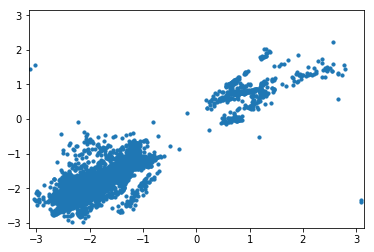

[[1.         0.92887733]
 [0.92887733 1.        ]]


In [576]:
plt.scatter(Y,np.dot(beta,X),s=10)
plt.xlim(-np.pi,np.pi)
plt.ylim(-np.pi,np.pi)
plt.show()

print(np.corrcoef(Y,np.dot(beta,X)))

In [463]:
0.98977608**2

0.9796566885401663

In [148]:
q = np.array([0.423560,0.362279])
ang = np.array([-2.578881])

In [215]:
np.sqrt(3)

1.7320508075688772

In [ ]:
0.423560	0.362279	-2.578881

In [89]:
dis = RA.PuckeringToDisplacement(q,ang,6)

In [92]:
dis

[-0.05893708505924772,
 0.06849940670798049,
 0.13833746077222514,
 -0.35473664990116344,
 0.3642989715498961,
 -0.1574621040696907]

In [ ]:
t1= a.iloc[k0,1]*np.cos(a.iloc[k0,3]+5*np.pi/12) + a.iloc[k0,2]
t2 = a.iloc[k0,20]
plt.scatter(t1,t2)

In [93]:
def fixzero(x):
    x_ = np.array([0.0]) if np.allclose(0,x, rtol=1e-06, atol=1e-08) else x
    return x_


def GetRingPuckerCoords(displacement,N):
    """
    Compute Ring Pucker Parameters
    
    Input:

    coordinates: array
    
    Return:

    qs: puckering amplitude (q_i>=0 for all i)
    
    angle: angle defined in 0<= phi_i <= 2pi 

    """

    z = displacement
    if N>4 and N<=20: # In our analysis, we fit it to be smaller than 16.
        if (N%2 == 0): # N even
            m = range(2,int((N/2)))
            cos_component = [np.dot(z,np.cos(2*np.pi*k*np.arange(0,N)/N)) for k in m]
            sin_component = [np.dot(z,np.sin(2*np.pi*k*np.arange(0,N)/N)) for k in m]
            qcos = fixzero(np.sqrt(2/N)*np.array(cos_component))
            qsin = fixzero(-np.sqrt(2/N)*np.array(sin_component))
            q = np.sqrt(qsin**2 + qcos**2)
            amplitude = np.append(q, (1/np.sqrt(N))*np.dot(z,np.cos(np.arange(0,N)*np.pi)).sum()).tolist()
            angle = np.arctan2(qsin,qcos).tolist()
        else: # N odd
            m = range(2,int((N-1)/2)+1)
            cos_component = [np.dot(z,np.cos(2*np.pi*k*np.arange(0,N)/N)) for k in m]
            sin_component = [np.dot(z,np.sin(2*np.pi*k*np.arange(0,N)/N)) for k in m]
            qcos = fixzero(np.sqrt(2/N)*np.array(cos_component))
            qsin = fixzero(-np.sqrt(2/N)*np.array(sin_component))
            amplitude = np.sqrt(qsin**2 + qcos**2).tolist()
            angle = np.arctan2(qsin,qcos).tolist()
    else:
        print("Ring Size is too big or too small")
    return amplitude, angle


In [94]:
GetRingPuckerCoords(dis,6)

([0.4235599999999999, 0.3622790000000001], [-2.5788809999999995])

In [112]:
GetRingPuckerCoords([dis[x%6] for x in range(2,8)],6)

([0.4235599999999998, 0.3622790000000002], [1.6099092047863912])

In [55]:
0.2204751228718341+2.2927990000000005

2.5132741228718345

In [113]:
(1.6099092047863912+2.5788809999999995)/np.pi

1.3333333333333333

In [99]:
2*np.pi/3

2.0943951023931953

In [38]:
np.pi*4/5

2.5132741228718345

In [ ]:
g1 = sns.pairplot(mono_five.iloc[mono_single][["q2","phi2"]],plot_kws=dict(s=10), diag_kws=dict(bins=50))
g1.axes[0,0].set_ylabel(r"$q_{2}$",size=15, rotation=0)
g1.axes[1,0].set_xlabel(r"$q_{2}$",rotation=0,size=15)
g1.axes[1,0].set_ylabel(r"$\phi_{2}$",rotation=0,size=15)
g1.axes[1,1].set_xlabel(r"$\phi_{2}$",rotation=0,size=15)
g1.axes[0,0].set_xticks([0,0.5,1])
g1.axes[0,0].set_yticks([0,0.5,1])
g1.axes[1,0].set_xticks([0,0.5,1])
g1.axes[1,0].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[1,1].set_xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[1,1].set_xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[0,0].set_yticklabels([r"0",r"0.5","1"])
g1.axes[1,0].set_yticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[1,0].set_xticklabels([r"0",r"0.5","1"])
g1.axes[1,1].set_xticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[0,1].set_visible(False)
plt.savefig("Fig/Macrocycle/mono_single_five.pdf",dpi=150,bbox_inches="tight")
plt.show()

In [ ]:
g1 = sns.pairplot(poly_five.iloc[poly_single][["q2","phi2"]],plot_kws=dict(s=10), diag_kws=dict(bins=50))
g1.axes[0,0].set_ylabel(r"$q_{2}$",size=15, rotation=0)
g1.axes[1,0].set_xlabel(r"$q_{2}$",rotation=0,size=15)
g1.axes[1,0].set_ylabel(r"$\phi_{2}$",rotation=0,size=15)
g1.axes[1,1].set_xlabel(r"$\phi_{2}$",rotation=0,size=15)
g1.axes[0,0].set_xticks([0,0.5,1])
g1.axes[0,0].set_yticks([0,0.5,1])
g1.axes[1,0].set_xticks([0,0.5,1])
g1.axes[1,0].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[1,1].set_xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[1,1].set_xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[0,0].set_yticklabels([r"0",r"0.5","1"])
g1.axes[1,0].set_yticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[1,0].set_xticklabels([r"0",r"0.5","1"])
g1.axes[1,1].set_xticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[0,1].set_visible(False)
plt.savefig("Fig/Macrocycle/poly_single_five.pdf",dpi=150,bbox_inches="tight")
plt.show()

In [ ]:
g1 = sns.pairplot(mono_five.iloc[mono_one][["q2","phi2"]],plot_kws=dict(s=10), diag_kws=dict(bins=50))
g1.axes[0,0].set_ylabel(r"$q_{2}$",size=15, rotation=0)
g1.axes[1,0].set_xlabel(r"$q_{2}$",rotation=0,size=15)
g1.axes[1,0].set_ylabel(r"$\phi_{2}$",rotation=0,size=15)
g1.axes[1,1].set_xlabel(r"$\phi_{2}$",rotation=0,size=15)
g1.axes[0,0].set_xticks([0,0.5])
g1.axes[0,0].set_yticks([0,0.5])
g1.axes[1,0].set_xticks([0,0.5])
g1.axes[1,0].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[1,1].set_xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[1,1].set_xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[0,0].set_yticklabels([r"0",r"0.5"])
g1.axes[1,0].set_yticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[1,0].set_xticklabels([r"0",r"0.5"])
g1.axes[1,1].set_xticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[0,1].set_visible(False)
plt.savefig("Fig/Macrocycle/mono_one_five.pdf",dpi=150,bbox_inches="tight")
plt.show()

In [ ]:
g1 = sns.pairplot(poly_five.iloc[poly_one][["q2","phi2"]],plot_kws=dict(s=10), diag_kws=dict(bins=50))
g1.axes[0,0].set_ylabel(r"$q_{2}$",size=15, rotation=0)
g1.axes[1,0].set_xlabel(r"$q_{2}$",rotation=0,size=15)
g1.axes[1,0].set_ylabel(r"$\phi_{2}$",rotation=0,size=15)
g1.axes[1,1].set_xlabel(r"$\phi_{2}$",rotation=0,size=15)
g1.axes[0,0].set_xticks([0,0.5])
g1.axes[0,0].set_yticks([0,0.5])
g1.axes[1,0].set_xticks([0,0.5])
g1.axes[1,0].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[1,1].set_xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[1,1].set_xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[0,0].set_yticklabels([r"0",r"0.5"])
g1.axes[1,0].set_yticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[1,0].set_xticklabels([r"0",r"0.5"])
g1.axes[1,1].set_xticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[0,1].set_visible(False)
plt.savefig("Fig/Macrocycle/poly_one_five.pdf",dpi=150,bbox_inches="tight")
plt.show()

In [ ]:
g1 = sns.pairplot(mono_five.iloc[mono_two][["q2","phi2"]],plot_kws=dict(s=10), diag_kws=dict(bins=50))
g1.axes[0,0].set_ylabel(r"$q_{2}$",size=15, rotation=0)
g1.axes[1,0].set_xlabel(r"$q_{2}$",rotation=0,size=15)
g1.axes[1,0].set_ylabel(r"$\phi_{2}$",rotation=0,size=15)
g1.axes[1,1].set_xlabel(r"$\phi_{2}$",rotation=0,size=15)
g1.axes[0,0].set_xticks([0,0.5,1])
g1.axes[0,0].set_yticks([0,0.5,1])
g1.axes[1,0].set_xticks([0,0.5,1])
g1.axes[1,0].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[1,1].set_xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[1,1].set_xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[0,0].set_yticklabels([r"0",r"0.5",r"1"])
g1.axes[1,0].set_yticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[1,0].set_xticklabels([r"0",r"0.5",r"1"])
g1.axes[1,1].set_xticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[0,1].set_visible(False)
plt.savefig("Fig/Macrocycle/mono_two_five.pdf",dpi=150,bbox_inches="tight")
plt.show()

In [ ]:
g1 = sns.pairplot(poly_five.iloc[poly_two][["q2","phi2"]],plot_kws=dict(s=10), diag_kws=dict(bins=50))
g1.axes[0,0].set_ylabel(r"$q_{2}$",size=15, rotation=0)
g1.axes[1,0].set_xlabel(r"$q_{2}$",rotation=0,size=15)
g1.axes[1,0].set_ylabel(r"$\phi_{2}$",rotation=0,size=15)
g1.axes[1,1].set_xlabel(r"$\phi_{2}$",rotation=0,size=15)
g1.axes[0,0].set_xticks([0,0.5,1])
g1.axes[0,0].set_yticks([0,0.5,1])
g1.axes[1,0].set_xticks([0,0.5,1])
g1.axes[1,0].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[1,1].set_xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[1,1].set_xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[0,0].set_yticklabels([r"0",r"0.5",r"1"])
g1.axes[1,0].set_yticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[1,0].set_xticklabels([r"0",r"0.5",r"1"])
g1.axes[1,1].set_xticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[0,1].set_visible(False)
plt.savefig("Fig/Macrocycle/poly_two_five.pdf",dpi=150,bbox_inches="tight")
plt.show()

In [63]:
six = pd.read_csv("six.csv")
monocyclic = []
polycyclic = []
for idx, item in enumerate(six[["A0","A1","A2","A3","A4","A5"]].values):
    if list(item)==["M","M","M","M","M","M"]:
        monocyclic.append(idx)
    else:
        polycyclic.append(idx)
        
mono_six = six.iloc[monocyclic].reset_index(drop=True)
poly_six = six.iloc[polycyclic].reset_index(drop=True)

mono_single = []
mono_one = []
mono_two = []
for idx, item in enumerate(mono_six[["B0","B1","B2","B3","B4","B5"]].values):
    check = [x==1.5 or x==2.0 for x in item]
    if sum(check)==0:
        mono_single.append(idx)
    elif sum(check)==1:
        mono_one.append(idx)
    else:
        mono_two.append(idx)

poly_single = []
poly_one = []
poly_two = []
for idx, item in enumerate(poly_six[["B0","B1","B2","B3","B4","B5"]].values):
    check = [x==1.5 or x==2.0 for x in list(item)]
    if sum(check)==0:
        poly_single.append(idx)
    elif sum(check)==1:
        poly_one.append(idx)
    else:
        poly_two.append(idx)

In [ ]:
g1 = sns.pairplot(mono_six.iloc[mono_single][["q2","q3","phi2"]],plot_kws=dict(s=10), diag_kws=dict(bins=50))
g1.axes[0,0].set_ylabel(r"$q_{2}$",size=15, rotation=0)
g1.axes[1,0].set_ylabel(r"$q_{3}$",rotation=0,size=15)
g1.axes[2,0].set_ylabel(r"$\phi_{2}$",rotation=0,size=15)
g1.axes[2,0].set_xlabel(r"$q_{2}$",rotation=0,size=15)
g1.axes[2,1].set_xlabel(r"$q_{3}$",rotation=0,size=15)
g1.axes[2,2].set_xlabel(r"$\phi_{2}$",rotation=0,size=15)
g1.axes[0,0].set_xticks([0,0.5,1])
g1.axes[0,0].set_yticks([0,0.5,1])
g1.axes[1,0].set_xticks([0,0.5,1])
g1.axes[1,0].set_yticks([-1,-0.5,0,0.5,1])
g1.axes[2,0].set_xticks([0,0.5,1])
g1.axes[2,0].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[1,1].set_xticks([-1,-0.5,0,0.5,1])
g1.axes[1,1].set_yticks([-1,-0.5,0,0.5,1])
g1.axes[2,1].set_xticks([-1,-0.5,0,0.5,1])
g1.axes[2,1].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[2,2].set_xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[2,2].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[2,0].set_yticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[2,0].set_yticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[2,1].set_xticklabels([r"0",r"0.5","1"])
g1.axes[2,1].set_xticklabels([r"-1",r"-0.5","0",r"0.5","1"])
g1.axes[2,2].set_xticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[0,1].set_visible(False)
g1.axes[0,2].set_visible(False)
g1.axes[1,2].set_visible(False)
plt.savefig("Fig/Macrocycle/mono_single_six.pdf",dpi=150,bbox_inches="tight")
plt.show()

In [ ]:
g1 = sns.pairplot(poly_six.iloc[poly_single][["q2","q3","phi2"]],plot_kws=dict(s=10), diag_kws=dict(bins=50))
g1.axes[0,0].set_ylabel(r"$q_{2}$",size=15, rotation=0)
g1.axes[1,0].set_ylabel(r"$q_{3}$",rotation=0,size=15)
g1.axes[2,0].set_ylabel(r"$\phi_{2}$",rotation=0,size=15)
g1.axes[2,0].set_xlabel(r"$q_{2}$",rotation=0,size=15)
g1.axes[2,1].set_xlabel(r"$q_{3}$",rotation=0,size=15)
g1.axes[2,2].set_xlabel(r"$\phi_{2}$",rotation=0,size=15)
g1.axes[0,0].set_xticks([0,0.5,1])
g1.axes[0,0].set_yticks([0,0.5,1])
g1.axes[1,0].set_xticks([0,0.5,1])
g1.axes[1,0].set_yticks([-1,-0.5,0,0.5,1])
g1.axes[2,0].set_xticks([0,0.5,1])
g1.axes[2,0].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[1,1].set_xticks([-1,-0.5,0,0.5,1])
g1.axes[1,1].set_yticks([-1,-0.5,0,0.5,1])
g1.axes[2,1].set_xticks([-1,-0.5,0,0.5,1])
g1.axes[2,1].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[2,2].set_xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[2,2].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[2,0].set_yticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[2,0].set_yticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[2,1].set_xticklabels([r"0",r"0.5","1"])
g1.axes[2,1].set_xticklabels([r"-1",r"-0.5","0",r"0.5","1"])
g1.axes[2,2].set_xticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[0,1].set_visible(False)
g1.axes[0,2].set_visible(False)
g1.axes[1,2].set_visible(False)
plt.savefig("Fig/Macrocycle/poly_single_six.pdf",dpi=150,bbox_inches="tight")
plt.show()

In [ ]:
g1 = sns.pairplot(mono_six.iloc[mono_one][["q2","q3","phi2"]],plot_kws=dict(s=10), diag_kws=dict(bins=50))
g1.axes[0,0].set_ylabel(r"$q_{2}$",size=15, rotation=0)
g1.axes[1,0].set_ylabel(r"$q_{3}$",rotation=0,size=15)
g1.axes[2,0].set_ylabel(r"$\phi_{2}$",rotation=0,size=15)
g1.axes[2,0].set_xlabel(r"$q_{2}$",rotation=0,size=15)
g1.axes[2,1].set_xlabel(r"$q_{3}$",rotation=0,size=15)
g1.axes[2,2].set_xlabel(r"$\phi_{2}$",rotation=0,size=15)
g1.axes[0,0].set_xticks([0,0.5,1])
g1.axes[0,0].set_yticks([0,0.5,1])
g1.axes[1,0].set_xticks([0,0.5,1])
g1.axes[1,0].set_yticks([-1,-0.5,0,0.5,1])
g1.axes[2,0].set_xticks([0,0.5,1])
g1.axes[2,0].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[1,1].set_xticks([-1,-0.5,0,0.5,1])
g1.axes[1,1].set_yticks([-1,-0.5,0,0.5,1])
g1.axes[2,1].set_xticks([-1,-0.5,0,0.5,1])
g1.axes[2,1].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[2,2].set_xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[2,2].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[2,0].set_yticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[2,0].set_yticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[2,1].set_xticklabels([r"0",r"0.5","1"])
g1.axes[2,1].set_xticklabels([r"-1",r"-0.5","0",r"0.5","1"])
g1.axes[2,2].set_xticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[0,1].set_visible(False)
g1.axes[0,2].set_visible(False)
g1.axes[1,2].set_visible(False)
plt.savefig("Fig/Macrocycle/mono_one_six.pdf",dpi=150,bbox_inches="tight")
plt.show()

In [ ]:
g1 = sns.pairplot(poly_six.iloc[poly_one][["q2","q3","phi2"]],plot_kws=dict(s=10), diag_kws=dict(bins=50))
g1.axes[0,0].set_ylabel(r"$q_{2}$",size=15, rotation=0)
g1.axes[1,0].set_ylabel(r"$q_{3}$",rotation=0,size=15)
g1.axes[2,0].set_ylabel(r"$\phi_{2}$",rotation=0,size=15)
g1.axes[2,0].set_xlabel(r"$q_{2}$",rotation=0,size=15)
g1.axes[2,1].set_xlabel(r"$q_{3}$",rotation=0,size=15)
g1.axes[2,2].set_xlabel(r"$\phi_{2}$",rotation=0,size=15)
g1.axes[0,0].set_xticks([0,0.5,1])
g1.axes[0,0].set_yticks([0,0.5,1])
g1.axes[1,0].set_xticks([0,0.5,1])
g1.axes[1,0].set_yticks([-1,-0.5,0,0.5,1])
g1.axes[2,0].set_xticks([0,0.5,1])
g1.axes[2,0].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[1,1].set_xticks([-1,-0.5,0,0.5,1])
g1.axes[1,1].set_yticks([-1,-0.5,0,0.5,1])
g1.axes[2,1].set_xticks([-1,-0.5,0,0.5,1])
g1.axes[2,1].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[2,2].set_xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[2,2].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[2,0].set_yticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[2,0].set_yticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[2,1].set_xticklabels([r"0",r"0.5","1"])
g1.axes[2,1].set_xticklabels([r"-1",r"-0.5","0",r"0.5","1"])
g1.axes[2,2].set_xticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[0,1].set_visible(False)
g1.axes[0,2].set_visible(False)
g1.axes[1,2].set_visible(False)
plt.savefig("Fig/Macrocycle/poly_one_six.pdf",dpi=150,bbox_inches="tight")
plt.show()

In [ ]:
g1 = sns.pairplot(mono_six.iloc[mono_two][["q2","q3","phi2"]],plot_kws=dict(s=10), diag_kws=dict(bins=50))
g1.axes[0,0].set_ylabel(r"$q_{2}$",size=15, rotation=0)
g1.axes[1,0].set_ylabel(r"$q_{3}$",rotation=0,size=15)
g1.axes[2,0].set_ylabel(r"$\phi_{2}$",rotation=0,size=15)
g1.axes[2,0].set_xlabel(r"$q_{2}$",rotation=0,size=15)
g1.axes[2,1].set_xlabel(r"$q_{3}$",rotation=0,size=15)
g1.axes[2,2].set_xlabel(r"$\phi_{2}$",rotation=0,size=15)
g1.axes[0,0].set_xticks([0,0.5,1])
g1.axes[0,0].set_yticks([0,0.5,1])
g1.axes[1,0].set_xticks([0,0.5,1])
g1.axes[1,0].set_yticks([-1,-0.5,0,0.5,1])
g1.axes[2,0].set_xticks([0,0.5,1])
g1.axes[2,0].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[1,1].set_xticks([-1,-0.5,0,0.5,1])
g1.axes[1,1].set_yticks([-1,-0.5,0,0.5,1])
g1.axes[1,1].set_xlim(-1,1)
g1.axes[2,1].set_xticks([-1,-0.5,0,0.5,1])
g1.axes[2,1].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[2,2].set_xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[2,2].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[2,0].set_yticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[2,0].set_yticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[2,1].set_xticklabels([r"0",r"0.5","1"])
g1.axes[2,1].set_xticklabels([r"-1",r"-0.5","0",r"0.5","1"])
g1.axes[2,2].set_xticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[0,1].set_visible(False)
g1.axes[0,2].set_visible(False)
g1.axes[1,2].set_visible(False)
plt.savefig("Fig/Macrocycle/mono_two_six.pdf",dpi=150,bbox_inches="tight")
plt.show()

In [ ]:
g1 = sns.pairplot(poly_six.iloc[poly_two][["q2","q3","phi2"]],plot_kws=dict(s=10), diag_kws=dict(bins=50))
g1.axes[0,0].set_ylabel(r"$q_{2}$",size=15, rotation=0)
g1.axes[1,0].set_ylabel(r"$q_{3}$",rotation=0,size=15)
g1.axes[2,0].set_ylabel(r"$\phi_{2}$",rotation=0,size=15)
g1.axes[2,0].set_xlabel(r"$q_{2}$",rotation=0,size=15)
g1.axes[2,1].set_xlabel(r"$q_{3}$",rotation=0,size=15)
g1.axes[2,2].set_xlabel(r"$\phi_{2}$",rotation=0,size=15)
g1.axes[0,0].set_xticks([0,0.5,1])
g1.axes[0,0].set_yticks([0,0.5,1])
g1.axes[1,0].set_xticks([0,0.5,1])
g1.axes[1,0].set_yticks([-1,-0.5,0,0.5,1])
g1.axes[2,0].set_xticks([0,0.5,1])
g1.axes[2,0].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[1,1].set_xticks([-1,-0.5,0,0.5,1])
g1.axes[1,1].set_yticks([-1,-0.5,0,0.5,1])
g1.axes[2,1].set_xticks([-1,-0.5,0,0.5,1])
g1.axes[2,1].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[2,2].set_xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[2,2].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[2,0].set_yticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[2,0].set_yticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[2,1].set_xticklabels([r"0",r"0.5","1"])
g1.axes[2,1].set_xticklabels([r"-1",r"-0.5","0",r"0.5","1"])
g1.axes[2,2].set_xticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[0,1].set_visible(False)
g1.axes[0,2].set_visible(False)
g1.axes[1,2].set_visible(False)
plt.savefig("Fig/Macrocycle/poly_two_six.pdf",dpi=150,bbox_inches="tight")
plt.show()

In [ ]:
seven = pd.read_csv("seven.csv")

In [ ]:
monocyclic = []
polycyclic = []
for idx, item in enumerate(seven[["A0","A1","A2","A3","A4","A5","A6"]].values):
    if list(item)==["M","M","M","M","M","M","M"]:
        monocyclic.append(idx)
    else:
        polycyclic.append(idx)
        
mono_seven = seven.iloc[monocyclic].reset_index(drop=True)
poly_seven = seven.iloc[polycyclic].reset_index(drop=True)

mono_single = []
mono_one = []
mono_two = []
for idx, item in enumerate(mono_seven[["B0","B1","B2","B3","B4","B5","B6"]].values):
    check = [x==1.5 or x==2.0 for x in item]
    if sum(check)==0:
        mono_single.append(idx)
    elif sum(check)==1:
        mono_one.append(idx)
    else:
        mono_two.append(idx)

poly_single = []
poly_one = []
poly_two = []
for idx, item in enumerate(poly_seven[["B0","B1","B2","B3","B4","B5","B6"]].values):
    check = [x==1.5 or x==2.0 for x in list(item)]
    if sum(check)==0:
        poly_single.append(idx)
    elif sum(check)==1:
        poly_one.append(idx)
    else:
        poly_two.append(idx)

In [ ]:
g1 = sns.pairplot(mono_seven.iloc[mono_single][["q2","q3","phi2","phi3"]],plot_kws=dict(s=15),diag_kws=dict(bins=30))
g1.axes[0,0].set_ylabel(r"$q_{2}$",size=15, rotation=0)
g1.axes[1,0].set_ylabel(r"$q_{3}$",rotation=0,size=15)
g1.axes[2,0].set_ylabel(r"$\phi_{2}$",rotation=0,size=15)
g1.axes[3,0].set_ylabel(r"$\phi_{3}$",rotation=0,size=15)
g1.axes[3,0].set_xlabel(r"$q_{2}$",rotation=0,size=15)
g1.axes[3,1].set_xlabel(r"$q_{3}$",rotation=0,size=15)
g1.axes[3,2].set_xlabel(r"$\phi_{2}$",rotation=0,size=15)
g1.axes[3,3].set_xlabel(r"$\phi_{3}$",rotation=0,size=15)
g1.axes[0,0].set_xticks([0,0.5,1,1.5])
g1.axes[0,0].set_yticks([0,0.5,1,1.5])
g1.axes[1,0].set_xticks([0,0.5,1,1.5])
g1.axes[1,0].set_yticks([0,0.5,1])
g1.axes[2,0].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[2,0].set_xticks([0,0.5,1,1.5])
g1.axes[3,0].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[3,0].set_xticks([0,0.5,1,1.5])
g1.axes[1,1].set_xticks([0,0.5,1])
g1.axes[1,1].set_yticks([0,0.5,1])
g1.axes[2,1].set_xticks([0,0.5,1])
g1.axes[2,1].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[2,2].set_xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[2,2].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[3,1].set_xticks([0,0.5,1])
g1.axes[3,1].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[3,2].set_xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[3,2].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[3,3].set_xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[3,3].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[0,0].set_yticklabels(["0","0.5","1.0","1.5"])
g1.axes[1,0].set_yticklabels(["0","0.5","1.0"])
g1.axes[2,0].set_yticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[3,0].set_yticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[3,0].set_xticklabels(["0","0.5","1","1.5"])
g1.axes[3,1].set_xticklabels(["0","0.5","1"])
g1.axes[3,2].set_xticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[3,3].set_xticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[0,1].set_visible(False)
g1.axes[0,2].set_visible(False)
g1.axes[0,3].set_visible(False)
g1.axes[1,2].set_visible(False)
g1.axes[1,3].set_visible(False)
g1.axes[2,3].set_visible(False)
plt.savefig("Fig/Macrocycle/mono_single_seven.pdf",dpi=150,bbox_inches="tight")
plt.show()

In [ ]:
g1 = sns.pairplot(poly_seven.iloc[poly_single][["q2","q3","phi2","phi3"]],plot_kws=dict(s=15),diag_kws=dict(bins=30))
g1.axes[0,0].set_ylabel(r"$q_{2}$",size=15, rotation=0)
g1.axes[1,0].set_ylabel(r"$q_{3}$",rotation=0,size=15)
g1.axes[2,0].set_ylabel(r"$\phi_{2}$",rotation=0,size=15)
g1.axes[3,0].set_ylabel(r"$\phi_{3}$",rotation=0,size=15)
g1.axes[3,0].set_xlabel(r"$q_{2}$",rotation=0,size=15)
g1.axes[3,1].set_xlabel(r"$q_{3}$",rotation=0,size=15)
g1.axes[3,2].set_xlabel(r"$\phi_{2}$",rotation=0,size=15)
g1.axes[3,3].set_xlabel(r"$\phi_{3}$",rotation=0,size=15)
g1.axes[0,0].set_xticks([0,0.5,1,1.5])
g1.axes[0,0].set_yticks([0,0.5,1,1.5])
g1.axes[1,0].set_xticks([0,0.5,1,1.5])
g1.axes[1,0].set_yticks([0,0.5,1])
g1.axes[2,0].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[2,0].set_xticks([0,0.5,1,1.5])
g1.axes[3,0].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[3,0].set_xticks([0,0.5,1,1.5])
g1.axes[1,1].set_xticks([0,0.5,1])
g1.axes[1,1].set_yticks([0,0.5,1])
g1.axes[2,1].set_xticks([0,0.5,1])
g1.axes[2,1].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[2,2].set_xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[2,2].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[3,1].set_xticks([0,0.5,1])
g1.axes[3,1].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[3,2].set_xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[3,2].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[3,3].set_xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[3,3].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[0,0].set_yticklabels(["0","0.5","1.0","1.5"])
g1.axes[1,0].set_yticklabels(["0","0.5","1.0"])
g1.axes[2,0].set_yticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[3,0].set_yticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[3,0].set_xticklabels(["0","0.5","1","1.5"])
g1.axes[3,1].set_xticklabels(["0","0.5","1"])
g1.axes[3,2].set_xticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[3,3].set_xticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[0,1].set_visible(False)
g1.axes[0,2].set_visible(False)
g1.axes[0,3].set_visible(False)
g1.axes[1,2].set_visible(False)
g1.axes[1,3].set_visible(False)
g1.axes[2,3].set_visible(False)
plt.savefig("Fig/Macrocycle/poly_single_seven.pdf",dpi=150,bbox_inches="tight")
plt.show()

In [ ]:
g1 = sns.pairplot(mono_seven.iloc[mono_one][["q2","q3","phi2","phi3"]],plot_kws=dict(s=15),diag_kws=dict(bins=10))
g1.axes[0,0].set_ylabel(r"$q_{2}$",size=15, rotation=0)
g1.axes[1,0].set_ylabel(r"$q_{3}$",rotation=0,size=15)
g1.axes[2,0].set_ylabel(r"$\phi_{2}$",rotation=0,size=15)
g1.axes[3,0].set_ylabel(r"$\phi_{3}$",rotation=0,size=15)
g1.axes[3,0].set_xlabel(r"$q_{2}$",rotation=0,size=15)
g1.axes[3,1].set_xlabel(r"$q_{3}$",rotation=0,size=15)
g1.axes[3,2].set_xlabel(r"$\phi_{2}$",rotation=0,size=15)
g1.axes[3,3].set_xlabel(r"$\phi_{3}$",rotation=0,size=15)
g1.axes[0,0].set_xticks([0,0.5,1,1.5])
g1.axes[0,0].set_yticks([0,0.5,1,1.5])
g1.axes[1,0].set_xticks([0,0.5,1,1.5])
g1.axes[1,0].set_yticks([0,0.5,1])
g1.axes[2,0].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[2,0].set_xticks([0,0.5,1,1.5])
g1.axes[3,0].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[3,0].set_xticks([0,0.5,1,1.5])
g1.axes[1,1].set_xticks([0,0.5,1])
g1.axes[1,1].set_yticks([0,0.5,1])
g1.axes[2,1].set_xticks([0,0.5,1])
g1.axes[2,1].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[2,2].set_xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[2,2].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[3,1].set_xticks([0,0.5,1])
g1.axes[3,1].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[3,2].set_xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[3,2].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[3,3].set_xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[3,3].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[0,0].set_yticklabels(["0","0.5","1.0","1.5"])
g1.axes[1,0].set_yticklabels(["0","0.5","1.0"])
g1.axes[2,0].set_yticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[3,0].set_yticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[3,0].set_xticklabels(["0","0.5","1","1.5"])
g1.axes[3,1].set_xticklabels(["0","0.5","1"])
g1.axes[3,2].set_xticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[3,3].set_xticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[0,1].set_visible(False)
g1.axes[0,2].set_visible(False)
g1.axes[0,3].set_visible(False)
g1.axes[1,2].set_visible(False)
g1.axes[1,3].set_visible(False)
g1.axes[2,3].set_visible(False)
plt.savefig("Fig/Macrocycle/mono_one_seven.pdf",dpi=150, bbox_inches="tight")
plt.show()

In [ ]:
g1 = sns.pairplot(poly_seven.iloc[poly_one][["q2","q3","phi2","phi3"]],plot_kws=dict(s=15),diag_kws=dict(bins=30))
g1.axes[0,0].set_ylabel(r"$q_{2}$",size=15, rotation=0)
g1.axes[1,0].set_ylabel(r"$q_{3}$",rotation=0,size=15)
g1.axes[2,0].set_ylabel(r"$\phi_{2}$",rotation=0,size=15)
g1.axes[3,0].set_ylabel(r"$\phi_{3}$",rotation=0,size=15)
g1.axes[3,0].set_xlabel(r"$q_{2}$",rotation=0,size=15)
g1.axes[3,1].set_xlabel(r"$q_{3}$",rotation=0,size=15)
g1.axes[3,2].set_xlabel(r"$\phi_{2}$",rotation=0,size=15)
g1.axes[3,3].set_xlabel(r"$\phi_{3}$",rotation=0,size=15)
g1.axes[0,0].set_xticks([0,0.5,1,1.5])
g1.axes[0,0].set_yticks([0,0.5,1,1.5])
g1.axes[1,0].set_xticks([0,0.5,1,1.5])
g1.axes[1,0].set_yticks([0,0.5,1])
g1.axes[2,0].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[2,0].set_xticks([0,0.5,1,1.5])
g1.axes[3,0].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[3,0].set_xticks([0,0.5,1,1.5])
g1.axes[1,1].set_xticks([0,0.5,1])
g1.axes[1,1].set_yticks([0,0.5,1])
g1.axes[2,1].set_xticks([0,0.5,1])
g1.axes[2,1].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[2,2].set_xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[2,2].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[3,1].set_xticks([0,0.5,1])
g1.axes[3,1].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[3,2].set_xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[3,2].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[3,3].set_xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[3,3].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[0,0].set_yticklabels(["0","0.5","1.0","1.5"])
g1.axes[1,0].set_yticklabels(["0","0.5","1.0"])
g1.axes[2,0].set_yticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[3,0].set_yticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[3,0].set_xticklabels(["0","0.5","1","1.5"])
g1.axes[3,1].set_xticklabels(["0","0.5","1"])
g1.axes[3,2].set_xticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[3,3].set_xticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[0,1].set_visible(False)
g1.axes[0,2].set_visible(False)
g1.axes[0,3].set_visible(False)
g1.axes[1,2].set_visible(False)
g1.axes[1,3].set_visible(False)
g1.axes[2,3].set_visible(False)
plt.savefig("Fig/Macrocycle/poly_one_seven.pdf",dpi=150, bbox_inches="tight")
plt.show()

In [ ]:
g1 = sns.pairplot(mono_seven.iloc[mono_two][["q2","q3","phi2","phi3"]],plot_kws=dict(s=15),diag_kws=dict(bins=20))
g1.axes[0,0].set_ylabel(r"$q_{2}$",size=15, rotation=0)
g1.axes[1,0].set_ylabel(r"$q_{3}$",rotation=0,size=15)
g1.axes[2,0].set_ylabel(r"$\phi_{2}$",rotation=0,size=15)
g1.axes[3,0].set_ylabel(r"$\phi_{3}$",rotation=0,size=15)
g1.axes[3,0].set_xlabel(r"$q_{2}$",rotation=0,size=15)
g1.axes[3,1].set_xlabel(r"$q_{3}$",rotation=0,size=15)
g1.axes[3,2].set_xlabel(r"$\phi_{2}$",rotation=0,size=15)
g1.axes[3,3].set_xlabel(r"$\phi_{3}$",rotation=0,size=15)
g1.axes[0,0].set_xticks([0,0.5,1,1.5])
g1.axes[0,0].set_yticks([0,0.5,1,1.5])
g1.axes[1,0].set_xticks([0,0.5,1,1.5])
g1.axes[1,0].set_yticks([0,0.5,1])
g1.axes[2,0].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[2,0].set_xticks([0,0.5,1,1.5])
g1.axes[3,0].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[3,0].set_xticks([0,0.5,1,1.5])
g1.axes[1,1].set_xticks([0,0.5,1])
g1.axes[1,1].set_yticks([0,0.5,1])
g1.axes[2,1].set_xticks([0,0.5,1])
g1.axes[2,1].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[2,2].set_xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[2,2].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[3,1].set_xticks([0,0.5,1])
g1.axes[3,1].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[3,2].set_xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[3,2].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[3,3].set_xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[3,3].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[0,0].set_yticklabels(["0","0.5","1.0","1.5"])
g1.axes[1,0].set_yticklabels(["0","0.5","1.0"])
g1.axes[2,0].set_yticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[3,0].set_yticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[3,0].set_xticklabels(["0","0.5","1","1.5"])
g1.axes[3,1].set_xticklabels(["0","0.5","1"])
g1.axes[3,2].set_xticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[3,3].set_xticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[0,1].set_visible(False)
g1.axes[0,2].set_visible(False)
g1.axes[0,3].set_visible(False)
g1.axes[1,2].set_visible(False)
g1.axes[1,3].set_visible(False)
g1.axes[2,3].set_visible(False)
plt.savefig("Fig/Macrocycle/mono_two_seven.pdf",dpi=150, bbox_inches="tight")
plt.show()

In [ ]:
g1 = sns.pairplot(poly_seven.iloc[poly_two][["q2","q3","phi2","phi3"]],plot_kws=dict(s=15),diag_kws=dict(bins=50))
g1.axes[0,0].set_ylabel(r"$q_{2}$",size=15, rotation=0)
g1.axes[1,0].set_ylabel(r"$q_{3}$",rotation=0,size=15)
g1.axes[2,0].set_ylabel(r"$\phi_{2}$",rotation=0,size=15)
g1.axes[3,0].set_ylabel(r"$\phi_{3}$",rotation=0,size=15)
g1.axes[3,0].set_xlabel(r"$q_{2}$",rotation=0,size=15)
g1.axes[3,1].set_xlabel(r"$q_{3}$",rotation=0,size=15)
g1.axes[3,2].set_xlabel(r"$\phi_{2}$",rotation=0,size=15)
g1.axes[3,3].set_xlabel(r"$\phi_{3}$",rotation=0,size=15)
g1.axes[0,0].set_xticks([0,0.5,1,1.5])
g1.axes[0,0].set_yticks([0,0.5,1,1.5])
g1.axes[1,0].set_xticks([0,0.5,1,1.5])
g1.axes[1,0].set_yticks([0,0.5,1])
g1.axes[2,0].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[2,0].set_xticks([0,0.5,1,1.5])
g1.axes[3,0].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[3,0].set_xticks([0,0.5,1,1.5])
g1.axes[1,1].set_xticks([0,0.5,1])
g1.axes[1,1].set_yticks([0,0.5,1])
g1.axes[2,1].set_xticks([0,0.5,1])
g1.axes[2,1].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[2,2].set_xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[2,2].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[3,1].set_xticks([0,0.5,1])
g1.axes[3,1].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[3,2].set_xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[3,2].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[3,3].set_xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[3,3].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[0,0].set_yticklabels(["0","0.5","1.0","1.5"])
g1.axes[1,0].set_yticklabels(["0","0.5","1.0"])
g1.axes[2,0].set_yticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[3,0].set_yticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[3,0].set_xticklabels(["0","0.5","1","1.5"])
g1.axes[3,1].set_xticklabels(["0","0.5","1"])
g1.axes[3,2].set_xticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[3,3].set_xticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[0,1].set_visible(False)
g1.axes[0,2].set_visible(False)
g1.axes[0,3].set_visible(False)
g1.axes[1,2].set_visible(False)
g1.axes[1,3].set_visible(False)
g1.axes[2,3].set_visible(False)
plt.savefig("Fig/Macrocycle/poly_two_seven.pdf",dpi=150, bbox_inches="tight")
plt.show()

In [ ]:
# Eight
eight = pd.read_csv("eight.csv")

In [ ]:
eight[["q2","q3","q4","phi2","phi3"]]

In [ ]:
g1 = sns.pairplot(six1.iloc[a2][["q3","phi2"]], plot_kws=dict(s=15),diag_kws=dict(bins=50))
g1.axes[0,0].set_ylabel(r"$q_{3}$",rotation=0,size=15)
g1.axes[1,0].set_xlabel(r"$q_{3}$",rotation=0,size=15)
g1.axes[1,0].set_ylabel(r"$\phi_{2}$",rotation=0,size=15)
g1.axes[1,1].set_xlabel(r"$\phi_{2}$",rotation=0,size=15)
g1.axes[0,0].set_xlim(-0.6,0.6)
g1.axes[0,0].set_xticks([-0.6,-0.4,-0.2,0,0.2,0.4,0.6])
g1.axes[0,0].set_ylim(-0.6,0.6)
g1.axes[0,1].set_ylim(-0.6,0.6)
g1.axes[1,0].set_yticks([-0.6,-0.4,-0.2,0,0.2,0.4,0.6])
g1.axes[0,1].set_xlim(-np.pi,np.pi)
g1.axes[1,0].set_xlim(-0.6,0.6)
g1.axes[1,0].set_ylim(-np.pi,np.pi)
g1.axes[1,0].set_xticks([-0.6,-0.4,-0.2,0,0.2,0.4,0.6])
g1.axes[1,0].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[1,0].set_yticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[1,1].set_xlim(-np.pi,np.pi)
g1.axes[1,1].set_ylim(-np.pi,np.pi)
g1.axes[1,1].set_xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[1,1].set_xticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[0,1].set_visible(False)
plt.savefig("Fig/Macrocycle/six_one_M_db.pdf",dpi=150, bbox_inches="tight")
plt.show()

In [ ]:
g1 = sns.pairplot(six2.iloc[b2][["q3","phi2"]], plot_kws=dict(s=15),diag_kws=dict(bins=50))
g1.axes[0,0].set_ylabel(r"$q_{3}$",rotation=0,size=15)
g1.axes[1,0].set_xlabel(r"$q_{3}$",rotation=0,size=15)
g1.axes[1,0].set_ylabel(r"$\phi_{2}$",rotation=0,size=15)
g1.axes[1,1].set_xlabel(r"$\phi_{2}$",rotation=0,size=15)
g1.axes[0,0].set_xlim(-0.6,0.6)
g1.axes[0,0].set_xticks([-0.6,-0.4,-0.2,0,0.2,0.4,0.6])
g1.axes[0,0].set_ylim(-0.6,0.6)
g1.axes[0,1].set_ylim(-0.6,0.6)
g1.axes[1,0].set_yticks([-0.6,-0.4,-0.2,0,0.2,0.4,0.6])
g1.axes[0,1].set_xlim(-np.pi,np.pi)
g1.axes[1,0].set_xlim(-0.6,0.6)
g1.axes[1,0].set_ylim(-np.pi,np.pi)
g1.axes[1,0].set_xticks([-0.6,-0.4,-0.2,0,0.2,0.4,0.6])
g1.axes[1,0].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[1,0].set_yticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[1,1].set_xlim(-np.pi,np.pi)
g1.axes[1,1].set_ylim(-np.pi,np.pi)
g1.axes[1,1].set_xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[1,1].set_xticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[0,1].set_visible(False)
plt.savefig("Fig/Macrocycle/six_one_BP_db.pdf",dpi=150, bbox_inches="tight")
plt.show()

In [ ]:
qq1 = six1.iloc[a2][np.abs(six1.iloc[a2]["q3"])<0.03].reset_index()
qq2 = six2.iloc[b2][np.abs(six2.iloc[b2]["q3"])<0.03].reset_index()

In [ ]:
q = six2.iloc[b2].reset_index()

In [ ]:
k = []
for item in q[["B0","B1","B2","B3","B4","B5"]].values:
    k.append(sum([x==1.5 for x in item])!=2)
     

In [ ]:
five

In [ ]:
g1 = sns.pairplot(q.iloc[k][["q3","phi2"]],plot_kws=dict(s=15), diag_kws=dict(bins=50))
g1.axes[0,0].set_ylabel(r"$q_{3}$",rotation=0,size=15)
g1.axes[1,0].set_xlabel(r"$q_{3}$",rotation=0,size=15)
g1.axes[1,0].set_ylabel(r"$\phi_{2}$",rotation=0,size=15)
g1.axes[1,1].set_xlabel(r"$\phi_{2}$",rotation=0,size=15)
g1.axes[0,0].set_xlim(-0.6,0.6)
g1.axes[0,0].set_xticks([-0.6,-0.4,-0.2,0,0.2,0.4,0.6])
g1.axes[0,0].set_ylim(-0.6,0.6)
g1.axes[0,1].set_ylim(-0.6,0.6)
g1.axes[1,0].set_yticks([-0.6,-0.4,-0.2,0,0.2,0.4,0.6])
g1.axes[0,1].set_xlim(-np.pi,np.pi)
g1.axes[1,0].set_xlim(-0.6,0.6)
g1.axes[1,0].set_ylim(-np.pi,np.pi)
g1.axes[1,0].set_xticks([-0.6,-0.4,-0.2,0,0.2,0.4,0.6])
g1.axes[1,0].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[1,0].set_yticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[1,1].set_xlim(-np.pi,np.pi)
g1.axes[1,1].set_ylim(-np.pi,np.pi)
g1.axes[1,1].set_xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[1,1].set_xticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[0,1].set_visible(False)
plt.show()

In [ ]:
ss = []
for idx, item in enumerate(qq[["B0","B1","B2","B3","B4","B5"]].values):
    if sum([x==1.5 for x in item])!=2:
        ss.append(idx)
        

In [ ]:
sns.pairplot(qq.iloc[ss][["q2","q3","phi2"]])

In [ ]:
qq.iloc[ss]

In [ ]:
np.unique(five["idx"]).shape

In [ ]:
mol = Chem.MolFromSmiles("C1CCCCC12CCCCCC2")

In [ ]:
RA.GetRingElement(mol, [5,4,3,2,1])

In [ ]:
ringatom = Chem.MolFromSmarts("[r]")

In [ ]:
def GetRingAtomType(mol, ringidx):
    """
    Input:
    
    mol: rdMol
    
    ringidx: list
    
    Return:
    
    outcome: list
    
    """
    ringatom = Chem.MolFromSmarts("[R]")
    monocyclicatom = Chem.MolFromSmarts("[R1]")
    bicyclicatom = Chem.MolFromSmarts("[R2]")
    ringatom_match = [a for x in mol.GetSubstructMatches(ringatom) for a in x]
    monocyclic_match = [a for x in mol.GetSubstructMatches(monocyclicatom) for a in x]
    bicyclic_match = [a for x in mol.GetSubstructMatches(bicyclicatom) for a in x]
    outcome = []
    for i in ringidx:
        if (i in ringatom_match) and (i in monocyclic_match):
            outcome.append("M")
        elif (i in ringatom_match) and (i in bicyclic_match):
            outcome.append("B")
        elif (i in ringatom_match) and (i not in monocyclic_match) and (i not in bicyclic_match):
            outcome.append("P")
        else:
            outcome.append("NA")
    return outcome

In [ ]:
list(range(2,2))

In [ ]:
[item[1] for item in RA.GetRingBonds(mol, range(6))]

In [ ]:
GetRingAtomType(mol, list(range(8)))

In [ ]:
mol.GetSubstructMatches(ringatom)

In [ ]:
mol.GetSubstructMatches(monocyclicatom)

In [ ]:
mol.GetSubstructMatches(bicyclicatom)

In [ ]:
aromatic = []
aliphatic = []
for row in five.iterrows():
    check = [x==1.5 for x in eval(row[1][2])]
    if all(check):
        aromatic.append(row[1])
    else:
        aliphatic.append(row[1])

In [ ]:
s1 = []
s2 = []
s3 = []
for item in aliphatic:
    check = sum(eval(item[2]))
    if check==5.5:
        tmp = eval(item[1])
        s1.append((tmp[0][0],tmp[1][0]))
    elif check==6:
        tmp = eval(item[1])
        s2.append((tmp[0][0],tmp[1][0]))
    elif check==5:
        tmp = eval(item[1])
        s3.append((tmp[0][0],tmp[1][0]))

In [ ]:
pd.DataFrame(s1)[0].hist(bins=50)
pd.DataFrame(s2)[0].hist(bins=50)
pd.DataFrame(s3)[0].hist(bins=50,alpha=.2)

In [ ]:
#pd.DataFrame(s1)[1].hist(bins=50)
#pd.DataFrame(s2)[1].hist(bins=50)
pd.DataFrame(s3)[0].hist(bins=100)

In [ ]:
sns.pairplot(pd.DataFrame(s1),plot_kws=dict(s=5), diag_kws=dict(bins=50))

In [ ]:
sns.pairplot(pd.DataFrame(single),plot_kws=dict(s=5), diag_kws=dict(bins=50))

In [ ]:
single

# Substituents Orientation

In [ ]:
fluorine = pd.read_csv("data/halogen_f.csv")
chlorine = pd.read_csv("data/halogen_cl.csv")
bromine = pd.read_csv("data/halogen_br.csv")
iodine = pd.read_csv("data/halogen_i.csv")
amine0 = pd.read_csv("data/amine_0.csv")
amine1 = pd.read_csv("data/amine_1.csv")
amine2 = pd.read_csv("data/amine_2.csv")
alkoxy = pd.read_csv("data/alkoxy.csv")
hydroxyl = pd.read_csv("data/hydroxyl.csv")
methyl = pd.read_csv("data/methyl.csv")
ketone = pd.read_csv("data/ketone.csv")
carboxylicacid_0 = pd.read_csv("data/carboxylicacid_0.csv")
carboxylicacid_1 = pd.read_csv("data/carboxylicacid_1.csv")
carboxylicacid_2 = pd.read_csv("data/carboxylicacid_2.csv")
carbonyl = pd.read_csv("data/carbonyl.csv")

In [ ]:
# Substituents
aliphatic = [len(aliphatic_fluorine),len(aliphatic_chlorine),len(aliphatic_bromine), len(aliphatic_iodine), 
             len(aliphatic_alkoxy), len(aliphatic_hydroxyl), len(aliphatic_amine0),len(aliphatic_amine1)
             ,len(aliphatic_amine2), len(aliphatic_methyl), len(aliphatic_ketone), len(aliphatic_carbonyl), len(aliphatic_carboxylicacid0),
            len(aliphatic_carboxylicacid1)]
aromatic = [len(aromatic_fluorine),len(aromatic_chlorine),len(aromatic_bromine), len(aromatic_iodine), 
           len(aromatic_alkoxy), len(aromatic_hydroxyl), len(aromatic_amine0), len(aromatic_amine1),
            len(aromatic_amine2), len(aromatic_methyl), len(aromatic_ketone), len(aromatic_carbonyl), len(aromatic_carboxylicacid0),
           len(aromatic_carboxylicacid1)]
types = ["aliphatic"]*len(aliphatic) + ["aromatic"]*len(aromatic)
name = ["Fluorine","Chlorine","Bromine","Iodine","Alkoxy","Hydroxyl","Tertiary Amine","Secondary Amine","Primary Amine", 
        "Methyl", "Ketone", "Carbonyl","Carboxylic Acid", "Carboxylic"]

dataframe = pd.DataFrame({"Types":types,"Count":aliphatic+aromatic, "Name":name*2})

sns.barplot(x="Name",y="Count", data=dataframe, hue="Types")
plt.yscale("log")
plt.xticks(range(len(name)), name, rotation='vertical')
plt.xlabel("Substituents",size=15)
plt.ylabel("Count",size=15)
plt.legend()
plt.show()

In [ ]:
aromatic_fluorine = fluorine[fluorine["aromatic"]==True]
aliphatic_fluorine = fluorine[fluorine["aromatic"]==False]

aromatic_chlorine = chlorine[chlorine["aromatic"]==True]
aliphatic_chlorine = chlorine[chlorine["aromatic"]==False]

aromatic_bromine = bromine[bromine["aromatic"]==True]
aliphatic_bromine = bromine[bromine["aromatic"]==False]

aromatic_iodine = iodine[iodine["aromatic"]==True]
aliphatic_iodine = iodine[iodine["aromatic"]==False]

aromatic_methyl = methyl[methyl["aromatic"]==True]
aliphatic_methyl = methyl[methyl["aromatic"]==False]

aromatic_alkoxy = alkoxy[alkoxy["aromatic"]==True]
aliphatic_alkoxy = alkoxy[alkoxy["aromatic"]==False]

aromatic_hydroxyl = hydroxyl[hydroxyl["aromatic"]==True]
aliphatic_hydroxyl = hydroxyl[hydroxyl["aromatic"]==False]

aromatic_amine0 = amine0[amine0["aromatic"]==True]
aliphatic_amine0 = amine0[amine0["aromatic"]==False]

aromatic_amine1 = amine1[amine1["aromatic"]==True]
aliphatic_amine1 = amine1[amine1["aromatic"]==False]

aromatic_amine2 = amine2[amine2["aromatic"]==True]
aliphatic_amine2 = amine2[amine2["aromatic"]==False]

aromatic_ketone = ketone[ketone["aromatic"]==True]
aliphatic_ketone = ketone[ketone["aromatic"]==False]

aromatic_carbonyl = carbonyl[carbonyl["aromatic"]==True]
aliphatic_carbonyl = carbonyl[carbonyl["aromatic"]==False]

aromatic_carboxylicacid0 = carboxylicacid_0[carboxylicacid_0["aromatic"]==True]
aliphatic_carboxylicacid0 = carboxylicacid_0[carboxylicacid_0["aromatic"]==False]

aromatic_carboxylicacid1 = carboxylicacid_1[carboxylicacid_1["aromatic"]==True]
aliphatic_carboxylicacid1 = carboxylicacid_1[carboxylicacid_1["aromatic"]==False]

In [ ]:
plt.hist(aromatic_fluorine["alpha"],bins=50)
plt.xlim(0,np.pi)
plt.xticks([0,np.pi/4, np.pi/2, 3*np.pi/4,np.pi],labels=[r"0",r"$\pi/4$",r"$\pi/2$",r"$3\pi/4$",r"$\pi$"])
plt.ylim(0,1800)
plt.xlabel(r"$\alpha$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aromatic_flurine_alpha.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(aromatic_chlorine["alpha"],bins=50)
plt.xlim(0,np.pi)
plt.xticks([0,np.pi/4, np.pi/2, 3*np.pi/4,np.pi],labels=[r"0",r"$\pi/4$",r"$\pi/2$",r"$3\pi/4$",r"$\pi$"])
plt.ylim(0,6000)
plt.xlabel(r"$\alpha$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aromatic_chlorine_alpha.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(aromatic_bromine["alpha"],bins=50)
plt.xlim(0,np.pi)
plt.xticks([0,np.pi/4, np.pi/2, 3*np.pi/4,np.pi],labels=[r"0",r"$\pi/4$",r"$\pi/2$",r"$3\pi/4$",r"$\pi$"])
plt.ylim(0,3000)
plt.xlabel(r"$\alpha$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aromatic_bromine_alpha.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(aromatic_iodine["alpha"],bins=50)
plt.xlim(0,np.pi)
plt.xticks([0,np.pi/4, np.pi/2, 3*np.pi/4,np.pi],labels=[r"0",r"$\pi/4$",r"$\pi/2$",r"$3\pi/4$",r"$\pi$"])
plt.ylim(0,600)
plt.xlabel(r"$\alpha$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aromatic_iodine_alpha.pdf",dpi=150,bbox_inches="tight")
plt.show()

In [ ]:
plt.hist(aromatic_fluorine["beta"],bins=30)
plt.xlim(-np.pi,np.pi)
plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],labels=[r"$-\pi$",r"$-\pi/2$",r"$0$",r"$\pi/2$",r"$\pi$"])
plt.ylim(0,1250)
plt.xlabel(r"$\beta$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aromatic_fluorine_beta.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(aromatic_chlorine["beta"],bins=30)
plt.xlim(-np.pi,np.pi)
plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],labels=[r"$-\pi$",r"$-\pi/2$",r"$0$",r"$\pi/2$",r"$\pi$"])
plt.ylim(0,1200)
plt.xlabel(r"$\beta$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aromatic_chlorine_beta.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(aromatic_bromine["beta"],bins=30)
plt.xlim(-np.pi,np.pi)
plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],labels=[r"$-\pi$",r"$-\pi/2$",r"$0$",r"$\pi/2$",r"$\pi$"])
plt.ylim(0,1200)
plt.xlabel(r"$\beta$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aromatic_bromine_beta.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(aromatic_iodine["beta"],bins=30)
plt.xlim(-np.pi,np.pi)
plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],labels=[r"$-\pi$",r"$-\pi/2$",r"$0$",r"$\pi/2$",r"$\pi$"])
plt.ylim(0,500)
plt.xlabel(r"$\beta$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aromatic_iodine_beta.pdf",dpi=150,bbox_inches="tight")
plt.show()

In [ ]:
plt.hist(aliphatic_fluorine["alpha"],bins=50)
plt.xlim(0,np.pi)
plt.xticks([0,np.pi/4, np.pi/2, 3*np.pi/4,np.pi],labels=[r"0",r"$\pi/4$",r"$\pi/2$",r"$3\pi/4$",r"$\pi$"])
plt.ylim(0,100)
plt.xlabel(r"$\alpha$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aliphatic_fluorine_alpha.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(aliphatic_chlorine["alpha"],bins=50)
plt.xlim(0,np.pi)
plt.xticks([0,np.pi/4, np.pi/2, 3*np.pi/4,np.pi],labels=[r"0",r"$\pi/4$",r"$\pi/2$",r"$3\pi/4$",r"$\pi$"])
plt.ylim(0,200)
plt.xlabel(r"$\alpha$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aliphatic_chlorine_alpha.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(aliphatic_bromine["alpha"],bins=50)
plt.xlim(0,np.pi)
plt.xticks([0,np.pi/4, np.pi/2, 3*np.pi/4,np.pi],labels=[r"0",r"$\pi/4$",r"$\pi/2$",r"$3\pi/4$",r"$\pi$"])
plt.ylim(0,100)
plt.xlabel(r"$\alpha$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aliphatic_bromine_alpha.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(aliphatic_iodine["alpha"],bins=50)
plt.xlim(0,np.pi)
plt.xticks([0,np.pi/4, np.pi/2, 3*np.pi/4,np.pi],labels=[r"0",r"$\pi/4$",r"$\pi/2$",r"$3\pi/4$",r"$\pi$"])
plt.ylim(0,50)
plt.xlabel(r"$\alpha$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aliphatic_iodine_alpha.pdf",dpi=150,bbox_inches="tight")
plt.show()

In [ ]:
plt.hist(aliphatic_fluorine["beta"],bins=100)
plt.xlim(-np.pi,np.pi)
plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],labels=[r"$-\pi$",r"$-\pi/2$",r"$0$",r"$\pi/2$",r"$\pi$"])
plt.ylim(0,500)
plt.xlabel(r"$\beta$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aliphatic_fluorine_beta.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(aliphatic_chlorine["beta"],bins=100)
plt.xlim(-np.pi,np.pi)
plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],labels=[r"$-\pi$",r"$-\pi/2$",r"$0$",r"$\pi/2$",r"$\pi$"])
plt.ylim(0,400)
plt.xlabel(r"$\beta$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aliphatic_chlorine_beta.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(aliphatic_bromine["beta"],bins=100)
plt.xlim(-np.pi,np.pi)
plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],labels=[r"-$\pi$",r"$-\pi/2$",r"$0$",r"$\pi/2$",r"$\pi$"])
plt.ylim(0,200)
plt.xlabel(r"$\beta$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aliphatic_bromine_beta.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(aliphatic_iodine["beta"],bins=100)
plt.xlim(-np.pi,np.pi)
plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],labels=[r"-$\pi$",r"$-\pi/2$",r"$0$",r"$\pi/2$",r"$\pi$"])
plt.ylim(0,50)
plt.xlabel(r"$\beta$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aliphatic_iodine_beta.pdf",dpi=150,bbox_inches="tight")
plt.show()

# Methyl

In [ ]:
plt.hist(aliphatic_methyl["alpha"],bins=100)
plt.xlim(0,np.pi)
plt.xticks([0,np.pi/4, np.pi/2, 3*np.pi/4,np.pi],labels=[r"0",r"$\pi/4$",r"$\pi/2$",r"$3\pi/4$",r"$\pi$"])
plt.ylim(0,5000)
plt.xlabel(r"$\alpha$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aliphatic_methyl_alpha.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(aromatic_methyl["alpha"],bins=100)
plt.xlim(0,np.pi)
plt.xticks([0,np.pi/4, np.pi/2, 3*np.pi/4,np.pi],labels=[r"0",r"$\pi/4$",r"$\pi/2$",r"$3\pi/4$",r"$\pi$"])
plt.ylim(0,25000)
plt.xlabel(r"$\alpha$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aromatic_methyl_alpha.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(aliphatic_methyl["beta"],bins=100)
plt.xlim(-np.pi,np.pi)
plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],labels=[r"$-\pi$",r"$-\pi/2$",r"$0$",r"$\pi/2$",r"$\pi$"])
plt.ylim(0,18000)
plt.xlabel(r"$\beta$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aliphatic_methyl_beta.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(aromatic_methyl["beta"],bins=100)
plt.xlim(-np.pi,np.pi)
plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],labels=[r"$-\pi$",r"$-\pi/2$",r"$0$",r"$\pi/2$",r"$\pi$"])
plt.ylim(0,4000)
plt.xlabel(r"$\beta$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aromatic_methyl_beta.pdf",dpi=150,bbox_inches="tight")
plt.show()

# Alkoxy and Hydroxyl

In [ ]:
plt.hist(aliphatic_alkoxy["alpha"],bins=100)
plt.xlim(0,np.pi)
plt.xticks([0,np.pi/4, np.pi/2, 3*np.pi/4,np.pi],labels=[r"0",r"$\pi/4$",r"$\pi/2$",r"$3\pi/4$",r"$\pi$"])
plt.ylim(0,800)
plt.xlabel(r"$\alpha$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aliphatic_alkoxy_alpha.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(aromatic_alkoxy["alpha"],bins=100)
plt.xlim(0,np.pi)
plt.xticks([0,np.pi/4, np.pi/2, 3*np.pi/4,np.pi],labels=[r"0",r"$\pi/4$",r"$\pi/2$",r"$3\pi/4$",r"$\pi$"])
plt.ylim(0,14000)
plt.xlabel(r"$\alpha$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aromatic_alkoxy_alpha.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(aliphatic_hydroxyl["alpha"],bins=100)
plt.xlim(0,np.pi)
plt.xticks([0,np.pi/4, np.pi/2, 3*np.pi/4,np.pi],labels=[r"0",r"$\pi/4$",r"$\pi/2$",r"$3\pi/4$",r"$\pi$"])
plt.ylim(0,2000)
plt.xlabel(r"$\alpha$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aliphatic_hydroxyl_alpha.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(aromatic_hydroxyl["alpha"],bins=100)
plt.xlim(0,np.pi)
plt.xticks([0,np.pi/4, np.pi/2, 3*np.pi/4,np.pi],labels=[r"0",r"$\pi/4$",r"$\pi/2$",r"$3\pi/4$",r"$\pi$"])
plt.ylim(0,8000)
plt.xlabel(r"$\alpha$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aromatic_hydroxyl_alpha.pdf",dpi=150,bbox_inches="tight")
plt.show()


In [ ]:
plt.hist(aliphatic_alkoxy["beta"],bins=100)
plt.xlim(-np.pi,np.pi)
plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],labels=[r"$-\pi$",r"$-\pi/2$",r"$0$",r"$\pi/2$",r"$\pi$"])
plt.ylim(0,2500)
plt.xlabel(r"$\beta$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aliphatic_alkoxy_beta.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(aromatic_alkoxy["beta"],bins=100)
plt.xlim(-np.pi,np.pi)
plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],labels=[r"$-\pi$",r"$-\pi/2$",r"$0$",r"$\pi/2$",r"$\pi$"])
plt.ylim(0,4500)
plt.xlabel(r"$\beta$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aromatic_alkoxy_beta.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(aliphatic_hydroxyl["beta"],bins=100)
plt.xlim(-np.pi,np.pi)
plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],labels=[r"$-\pi$",r"$-\pi/2$",r"$0$",r"$\pi/2$",r"$\pi$"])
plt.ylim(0,13000)
plt.xlabel(r"$\beta$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aliphatic_hydroxyl_beta.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(aromatic_hydroxyl["beta"],bins=100)
plt.xlim(-np.pi,np.pi)
plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],labels=[r"$-\pi$",r"$-\pi/2$",r"$0$",r"$\pi/2$",r"$\pi$"])
plt.ylim(0,1500)
plt.xlabel(r"$\beta$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aromatic_hydroxyl_beta.pdf",dpi=150,bbox_inches="tight")
plt.show()

# Amine

In [ ]:
## Aromatic
plt.hist(aromatic_amine0["alpha"],bins=100)
plt.xlim(0,np.pi)
plt.xticks([0,np.pi/4, np.pi/2, 3*np.pi/4,np.pi],labels=[r"0",r"$\pi/4$",r"$\pi/2$",r"$3\pi/4$",r"$\pi$"])
plt.ylim(0,7000)
plt.xlabel(r"$\alpha$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aromatic_amine0_alpha.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(aromatic_amine1["alpha"],bins=100)
plt.xlim(0,np.pi)
plt.xticks([0,np.pi/4, np.pi/2, 3*np.pi/4,np.pi],labels=[r"0",r"$\pi/4$",r"$\pi/2$",r"$3\pi/4$",r"$\pi$"])
plt.ylim(0,2000)
plt.xlabel(r"$\alpha$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aromatic_amine1_alpha.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(aromatic_amine2["alpha"],bins=100)
plt.xlim(0,np.pi)
plt.xticks([0,np.pi/4, np.pi/2, 3*np.pi/4,np.pi],labels=[r"0",r"$\pi/4$",r"$\pi/2$",r"$3\pi/4$",r"$\pi$"])
plt.ylim(0,150)
plt.xlabel(r"$\alpha$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aromatic_amine2_alpha.pdf",dpi=150,bbox_inches="tight")
plt.show()


plt.hist(aliphatic_amine0["alpha"],bins=100)
plt.xlim(0,np.pi)
plt.xticks([0,np.pi/4, np.pi/2, 3*np.pi/4,np.pi],labels=[r"0",r"$\pi/4$",r"$\pi/2$",r"$3\pi/4$",r"$\pi$"])
plt.ylim(0,100)
plt.xlabel(r"$\alpha$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aliphatic_amine0_alpha.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(aliphatic_amine1["alpha"],bins=100)
plt.xlim(0,np.pi)
plt.xticks([0,np.pi/4, np.pi/2, 3*np.pi/4,np.pi],labels=[r"0",r"$\pi/4$",r"$\pi/2$",r"$3\pi/4$",r"$\pi$"])
plt.ylim(0,250)
plt.xlabel(r"$\alpha$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aliphatic_amine1_alpha.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(aliphatic_amine2["alpha"],bins=100)
plt.xlim(0,np.pi)
plt.xticks([0,np.pi/4, np.pi/2, 3*np.pi/4,np.pi],labels=[r"0",r"$\pi/4$",r"$\pi/2$",r"$3\pi/4$",r"$\pi$"])
plt.ylim(0,150)
plt.xlabel(r"$\alpha$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aliphatic_amine2_alpha.pdf",dpi=150,bbox_inches="tight")
plt.show()



In [ ]:
## Aromatic
plt.hist(aromatic_amine0["beta"],bins=100)
plt.xlim(-np.pi,np.pi)
plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],labels=[r"$-\pi$",r"$-\pi/2$",r"$0$",r"$\pi/2$",r"$\pi$"])
plt.ylim(0,5500)
plt.xlabel(r"$\beta$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aromatic_amine0_beta.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(aromatic_amine1["beta"],bins=100)
plt.xlim(-np.pi,np.pi)
plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],labels=[r"$-\pi$",r"$-\pi/2$",r"$0$",r"$\pi/2$",r"$\pi$"])
plt.ylim(0,600)
plt.xlabel(r"$\beta$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aromatic_amine1_beta.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(aromatic_amine2["beta"],bins=100)
plt.xlim(-np.pi,np.pi)
plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],labels=[r"$-\pi$",r"$-\pi/2$",r"$0$",r"$\pi/2$",r"$\pi$"])
plt.ylim(0,300)
plt.xlabel(r"$\beta$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aromatic_amine2_beta.pdf",dpi=150,bbox_inches="tight")
plt.show()

## Aliphatic
plt.hist(aliphatic_amine0["beta"],bins=100)
plt.xlim(-np.pi,np.pi)
plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],labels=[r"$-\pi$",r"$-\pi/2$",r"$0$",r"$\pi/2$",r"$\pi$"])
plt.ylim(0,600)
plt.xlabel(r"$\beta$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aliphatic_amine0_beta.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(aliphatic_amine1["beta"],bins=100)
plt.xlim(-np.pi,np.pi)
plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],labels=[r"$-\pi$",r"$-\pi/2$",r"$0$",r"$\pi/2$",r"$\pi$"])
plt.ylim(0,1500)
plt.xlabel(r"$\beta$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aliphatic_amine1_beta.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(aliphatic_amine2["beta"],bins=100)
plt.xlim(-np.pi,np.pi)
plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],labels=[r"$-\pi$",r"$-\pi/2$",r"$0$",r"$\pi/2$",r"$\pi$"])
plt.ylim(0,300)
plt.xlabel(r"$\beta$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aliphatic_amine2_beta.pdf",dpi=150,bbox_inches="tight")
plt.show()

# Ketone

In [ ]:
plt.hist(aliphatic_ketone["alpha"],bins=100)
plt.xlim(0,np.pi)
plt.xticks([0,np.pi/4, np.pi/2, 3*np.pi/4,np.pi],labels=[r"0",r"$\pi/4$",r"$\pi/2$",r"$3\pi/4$",r"$\pi$"])
plt.ylim(0,800)
plt.xlabel(r"$\alpha$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aliphatic_ketone_alpha.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(aromatic_ketone["alpha"],bins=100)
plt.xlim(0,np.pi)
plt.xticks([0,np.pi/4, np.pi/2, 3*np.pi/4,np.pi],labels=[r"0",r"$\pi/4$",r"$\pi/2$",r"$3\pi/4$",r"$\pi$"])
plt.ylim(0,9000)
plt.xlabel(r"$\alpha$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aromatic_ketone_alpha.pdf",dpi=150,bbox_inches="tight")
plt.show()

In [ ]:
plt.hist(aliphatic_ketone["beta"],bins=100)
plt.xlim(-np.pi,np.pi)
plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],labels=[r"$-\pi$",r"$-\pi/2$",r"$0$",r"$\pi/2$",r"$\pi$"])
plt.ylim(0,5500)
plt.xlabel(r"$\beta$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aliphatic_ketone_beta.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(aromatic_ketone["beta"],bins=100)
plt.xlim(-np.pi,np.pi)
plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],labels=[r"$-\pi$",r"$-\pi/2$",r"$0$",r"$\pi/2$",r"$\pi$"])
plt.ylim(0,1500)
plt.xlabel(r"$\beta$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aromatic_ketone_beta.pdf",dpi=150,bbox_inches="tight")
plt.show()

# Carbonyl

In [ ]:
plt.hist(aliphatic_carbonyl["alpha"],bins=100)
plt.xlim(0,np.pi)
plt.xticks([0,np.pi/4, np.pi/2, 3*np.pi/4,np.pi],labels=[r"0",r"$\pi/4$",r"$\pi/2$",r"$3\pi/4$",r"$\pi$"])
plt.ylim(0,10000)
plt.xlabel(r"$\alpha$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aliphatic_carbonyl_alpha.pdf",dpi=150,bbox_inches="tight")
plt.show()

In [ ]:
plt.hist(aliphatic_carbonyl["beta"],bins=100)
plt.xlim(-np.pi,np.pi)
plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],labels=[r"$-\pi$",r"$-\pi/2$",r"$0$",r"$\pi/2$",r"$\pi$"])
plt.ylim(0,35000)
plt.xlabel(r"$\beta$",size=15)
plt.ylabel("Count",size=15)
#plt.savefig("aliphatic_carbonyl_beta.pdf",dpi=150,bbox_inches="tight")
plt.show()


In [ ]:
alkoxy = Chem.SDMolSupplier("molecule/f.sdf")
alkoxy_smarts = "[R][F&!R]"
c1 = []
for idx, mol in enumerate(alkoxy):
    bonds = []
    for bond in mol.GetBonds():
        bonds.append((bond.GetBeginAtom().GetIdx(),bond.GetEndAtom().GetIdx()))
    data = py_rdl.Calculator.get_calculated_result(bonds)
    for urf in data.urfs:
        rcs = data.get_relevant_cycles_for_urf(urf)
        for rc in rcs:
            if (len(list(rc.nodes))<20) and (len(list(rc.nodes))>4):
                ringloop = RA.Rearrangement(mol, list(rc.nodes))
                coord = np.array([mol.GetConformer().GetAtomPosition(atom) for atom in ringloop])
                ox = RA.GetSubstituent(mol, list(rc.nodes), alkoxy_smarts)
                if any(ox):
                    for i in ox:
                        ccoord = RA.Translate(coord)
                        cptmp = RA.GetRingPuckerCoords(ccoord)
                        ohpos = RA.GetRingSubstituentPosition(mol, ringloop, i)
                        b = RA.GetRingBonds(mol, ringloop)
                        c1.append((idx,cptmp,ohpos,b))


In [ ]:
RA.GetRingBonds(mol)

In [ ]:
mol = Chem.MolFromSmiles("c1ccccc1")

In [ ]:
RA.GetRingBonds(mol,list(range(6)))

In [ ]:
plt.hist(mono_five.iloc[mono_single]["q2"],bins=50)
plt.ylabel("Count",size=15)
plt.xlabel(r"$q_{2}$",size=15)
plt.xlim(0,1)
plt.ylim(0,1200)
#plt.savefig("Fig/Macrocycle/mono_single_five_q2.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(poly_five.iloc[poly_single]["q2"],bins=50)
plt.ylabel("Count",size=15)
plt.xlabel(r"$q_{2}$",size=15)
plt.xlim(0,1)
plt.ylim(0,2500)
#plt.savefig("Fig/Macrocycle/poly_single_five_q2.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(mono_five.iloc[mono_single]["phi2"],bins=50)
plt.ylabel("Count",size=15)
plt.xlabel(r"$\phi_{2}$",size=15)
plt.xlim(-np.pi,np.pi)
plt.xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi],
           labels=[r"$-\pi$",r"$-\pi/2$",r"0",r"$\pi/2$",r"$\pi$"])
plt.ylim(0,600)
#plt.savefig("Fig/Macrocycle/mono_single_five_phi2.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(poly_five.iloc[poly_single]["phi2"],bins=50)
plt.ylabel("Count",size=15)
plt.xlabel(r"$\phi_{2}$",size=15)
plt.xlim(-np.pi,np.pi)
plt.xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi],
           labels=[r"$-\pi$",r"$-\pi/2$",r"0",r"$\pi/2$",r"$\pi$"])
plt.ylim(0,1400)
#plt.savefig("Fig/Macrocycle/poly_single_five_phi2.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(mono_five.iloc[mono_one]["q2"],bins=50)
plt.ylabel("Count",size=15)
plt.xlabel(r"$q_{2}$",size=15)
plt.xlim(0,1)
plt.ylim(0,1200)
#plt.savefig("Fig/Macrocycle/mono_one_five_q2.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(poly_five.iloc[poly_one]["q2"],bins=50)
plt.ylabel("Count",size=15)
plt.xlabel(r"$q_{2}$",size=15)
plt.xlim(0,1)
plt.ylim(0,7000)
#plt.savefig("Fig/Macrocycle/poly_one_five_q2.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(mono_five.iloc[mono_one]["phi2"],bins=50)
plt.ylabel("Count",size=15)
plt.xlabel(r"$\phi_{2}$",size=15)
plt.xlim(-np.pi,np.pi)
plt.xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi],
           labels=[r"$-\pi$",r"$-\pi/2$",r"0",r"$\pi/2$",r"$\pi$"])
plt.ylim(0,350)
#plt.savefig("Fig/Macrocycle/mono_one_five_phi2.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(poly_five.iloc[poly_one]["phi2"],bins=50)
plt.ylabel("Count",size=15)
plt.xlabel(r"$\phi_{2}$",size=15)
plt.xlim(-np.pi,np.pi)
plt.xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi],
           labels=[r"$-\pi$",r"$-\pi/2$",r"0",r"$\pi/2$",r"$\pi$"])
plt.ylim(0,3000)
#plt.savefig("Fig/Macrocycle/poly_one_five_phi2.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(mono_five.iloc[mono_two]["q2"],bins=50)
plt.ylabel("Count",size=15)
plt.xlabel(r"$q_{2}$",size=15)
plt.xlim(0,1)
plt.ylim(0,15000)
#plt.savefig("Fig/Macrocycle/mono_two_five_q2.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(poly_five.iloc[poly_two]["q2"],bins=50)
plt.ylabel("Count",size=15)
plt.xlabel(r"$q_{2}$",size=15)
plt.xlim(0,1)
plt.ylim(0,15000)
#plt.savefig("Fig/Macrocycle/poly_two_five_q2.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(mono_five.iloc[mono_two]["phi2"],bins=50)
plt.ylabel("Count",size=15)
plt.xlabel(r"$\phi_{2}$",size=15)
plt.xlim(-np.pi,np.pi)
plt.xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi],
           labels=[r"$-\pi$",r"$-\pi/2$",r"0",r"$\pi/2$",r"$\pi$"])
plt.ylim(0,450)
#plt.savefig("Fig/Macrocycle/mono_two_five_phi2.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(poly_five.iloc[poly_two]["phi2"],bins=50)
plt.ylabel("Count",size=15)
plt.xlabel(r"$\phi_{2}$",size=15)
plt.xlim(-np.pi,np.pi)
plt.xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi],
           labels=[r"$-\pi$",r"$-\pi/2$",r"0",r"$\pi/2$",r"$\pi$"])
plt.ylim(0,1300)
#plt.savefig("Fig/Macrocycle/poly_two_five_phi2.pdf",dpi=150,bbox_inches="tight")
plt.show()